# Analysis Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc
from scipy import integrate
import warnings
warnings.filterwarnings('ignore')

def load_data(path:str):
    """
    Loads the data from the .txt file.

    :param str path: Path to the file.
    :returns: Data from ch1, ch2, and time array separately.
    """
    # Load the data
    data = np.loadtxt(path)

    # Checking dimensions
    num_samples, total_cols = data.shape
    assert total_cols == 20, "Expecting 20 columns: 10 waveforms for each of 2 channels"

    # Split columns into two groups of 10 each
    ch1_waveforms = data[:, 0:10]   # first 10 columns: Channel 1
    ch2_waveforms = data[:, 10:20]  # next 10 columns: Channel 2

    # Time axis setup
    dt = data[0][0] # oscilloscope sampling period in seconds
    time = np.arange(num_samples) * dt * 1e6 # s-> us

    return ch1_waveforms, ch2_waveforms, time

def clean_data(waveforms):
    """
    Subtracts the baseline from the waveforms and takes the average.

    :param waveforms: 10 waveforms that need to be cleaned (list).
    :returns: One waveform (list).
    """
    baseline_region = slice(0, int(0.1 * len(waveforms)))  # first 10% of samples

    # Subtract pedestal for Channel 1
    baselines = np.mean(waveforms[baseline_region, :], axis=0)  # shape: (10,)
    waveforms_corrected = waveforms - baselines  # broadcasting

    # Recompute averages after pedestal subtraction
    avg_waveforms = np.mean(waveforms_corrected, axis=1)

    return avg_waveforms

def get_charge(ch_clean, time, is_anode):
    """
    Fits the cleaned up version, and performs an integral to find the charge.

    :param ch_clean: cleaned up waveform for the channel.
    :param time: time array.
    :param bool is_anode: whether the charge is of the anode or cathode
    :returns: charge in pC.
    """
    # Initial guesses
    x_bar_guess = time[np.argmax(ch_clean)]
    sigma_guess = (time[-1] - time[0]) / 10
    N_guess = np.max(ch_clean)
    p0 = [1.5, 3.0, x_bar_guess, sigma_guess, N_guess]  # [alpha, n, x̄, sigma, N]

    # Fitting
    popt, pcov = curve_fit(crystal_ball, time, ch_clean, p0=p0)
    
    # Integrating
    time_range = (time[0],time[-1])
    area, error = integrate_crystal_ball(popt, time_range, 'quad')

    # Getting charge
    if is_anode:
        trans_impedance = 207e-3 # Ohm
    else:
        trans_impedance = 213e-3 # Ohm

    charge = trans_impedance * area * 20 # idk why by 20/25!!!

    return charge

def analysis(path:str):
    """
    Performs the full analysis of the data to get anode charge and cathode charge.

    :param str path: Path to the file.
    :returns: Anode and Cathode charge.
    """
    ch1, ch2, time = load_data(path)

    clean_ch1 = clean_data(ch1)
    clean_ch2 = clean_data(ch2)

    cathode_charge = get_charge(clean_ch1, time, False)
    anode_charge = get_charge(clean_ch2, time, True)

    return cathode_charge, anode_charge

# Fit Functions

In [2]:
def crystal_ball(x, alpha, n, x_bar, sigma, N):
    """
    Crystal Ball function (reflective version)
    
    Parameters:
    alpha: tail parameter (controls where the tail starts)
    n: tail slope parameter
    x_bar: mean
    sigma: width parameter
    N: normalization constant
    """
    t = (x - x_bar) / sigma
    
    # For reflective crystal ball, we flip the condition
    # Standard crystal ball has tail on left side (t < -alpha)
    # Reflective version has tail on right side (t > alpha)
    
    result = np.zeros_like(x)
    
    # Core region (Gaussian part)
    core_mask = t <= alpha
    result[core_mask] = N * np.exp(-0.5 * t[core_mask]**2)
    
    # Tail region (power law)
    tail_mask = t > alpha
    if np.any(tail_mask):
        A = (n / alpha)**n * np.exp(-0.5 * alpha**2)
        B = n / alpha - alpha
        result[tail_mask] = N * A * (B + t[tail_mask])**(-n)
    
    return result

def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0)**2 / (2 * sigma**2))

def integrate_crystal_ball(popt, time_range, method='quad'):
    """
    Integrate Crystal Ball function over a time range
    
    Parameters:
    -----------
    popt : tuple
        Fit parameters (N, mu, sigma, alpha, n)
    time_range : tuple
        (t_min, t_max) integration bounds
    method : str
        Integration method ('quad', 'trapz', 'simpson')
    
    Returns:
    --------
    float
        Integral value
    """
    t_min, t_max = time_range
    
    if method == 'quad':
        # Adaptive quadrature (most accurate for smooth functions)
        result, error = integrate.quad(
            lambda t: crystal_ball(t, *popt), 
            t_min, t_max
        )
        return result, error
    
    elif method == 'trapz':
        # Trapezoidal rule (good for tabulated data)
        t_points = np.linspace(t_min, t_max, 1000)
        y_values = crystal_ball(t_points, *popt)
        result = integrate.trapz(y_values, t_points)
        return result
    
    elif method == 'simpson':
        # Simpson's rule (good balance of accuracy and speed)
        t_points = np.linspace(t_min, t_max, 1001)  # Odd number for Simpson
        y_values = crystal_ball(t_points, *popt)
        result = integrate.simpson(y_values, t_points)
        return result
    
    else:
        raise ValueError("Method must be 'quad', 'trapz', or 'simpson'")

In [3]:
voltages = [i*16 for i in range(21)]

cathode_charges = []
anode_charges = []

for i in range(21):
    voltage_grid = str(voltages[i])
    voltage_anode = str(voltages[i])
    path = "data/VG" + voltage_grid + "VA" + voltage_anode + ".txt"
    cathode_charge, anode_charge = analysis(path)
    cathode_charges.append(cathode_charge)
    anode_charges.append(anode_charge)

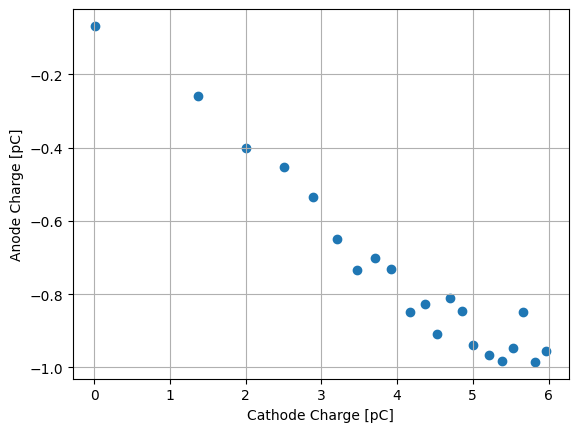

In [4]:
plt.scatter(cathode_charges, anode_charges)
plt.xlabel("Cathode Charge [pC]")
plt.ylabel("Anode Charge [pC]")
plt.grid(True)